  Preparing metadata (setup.py) ... done
Raw shape: (15120, 56)
   Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            221             23

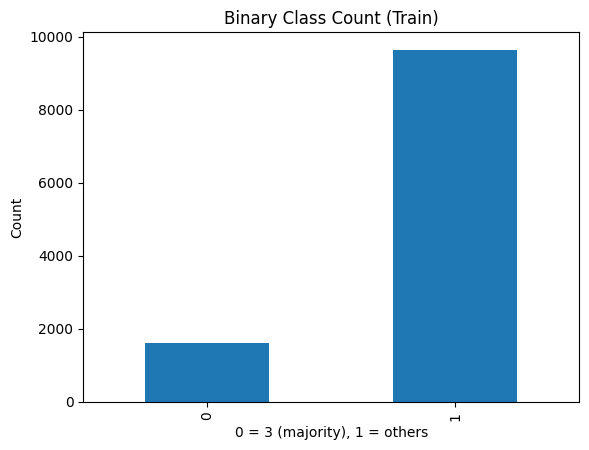

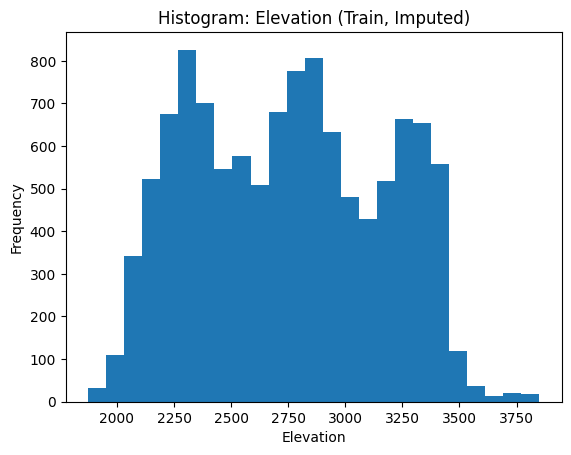

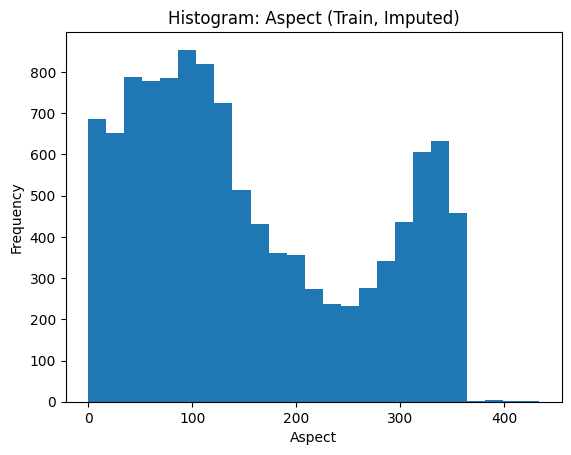

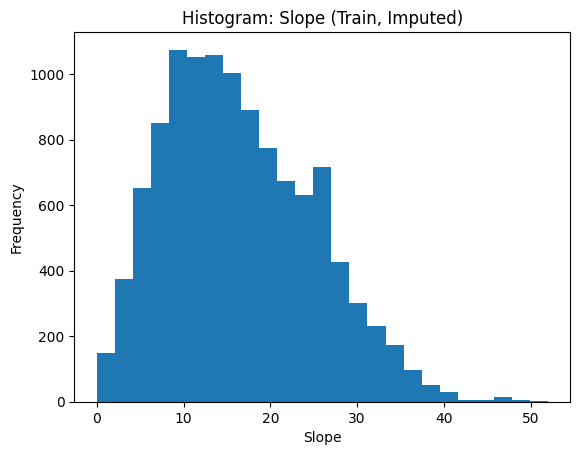

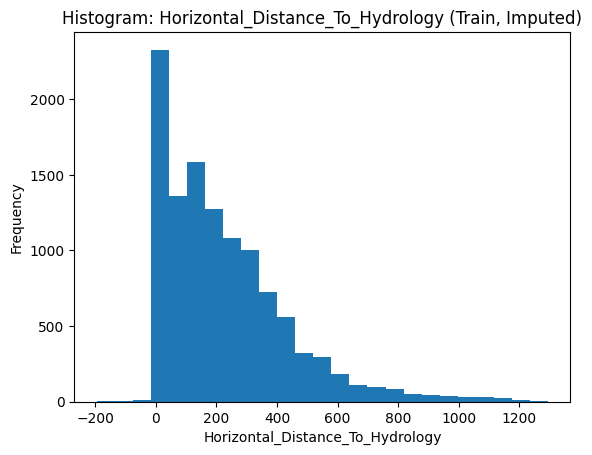

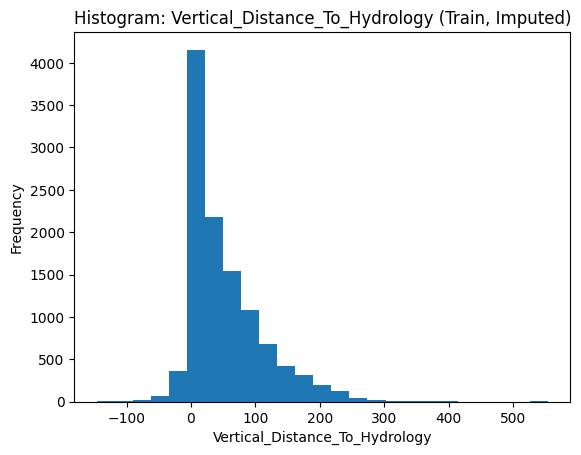

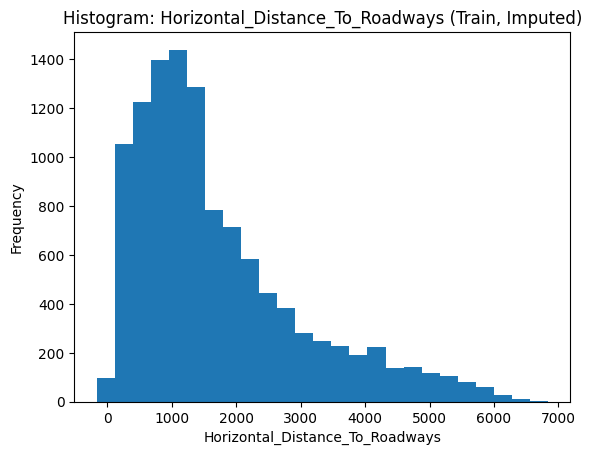

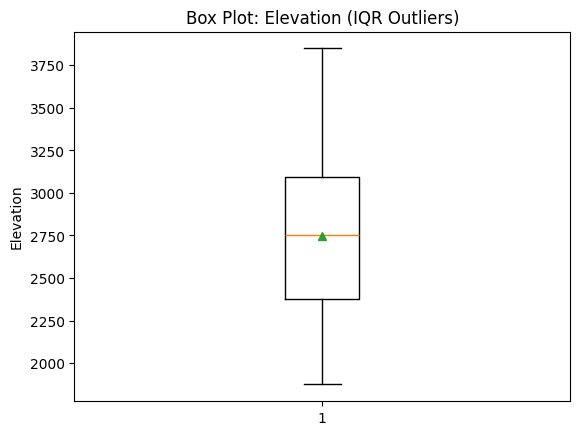

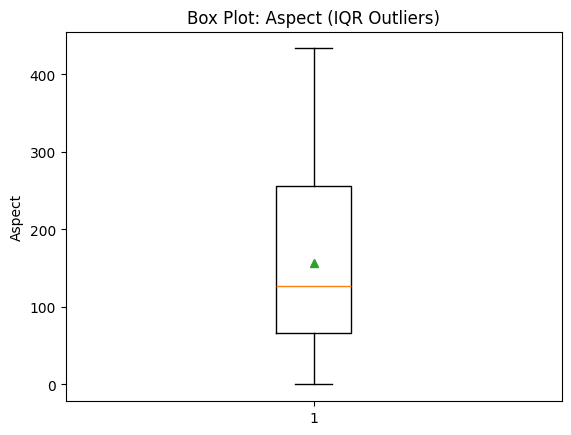

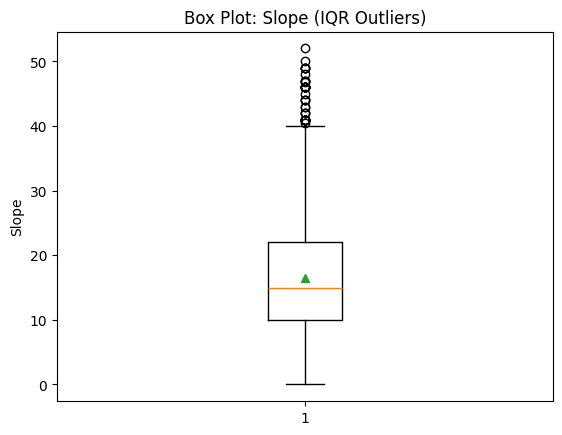

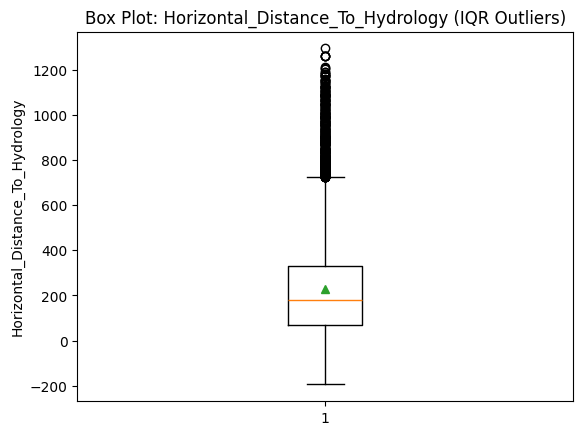

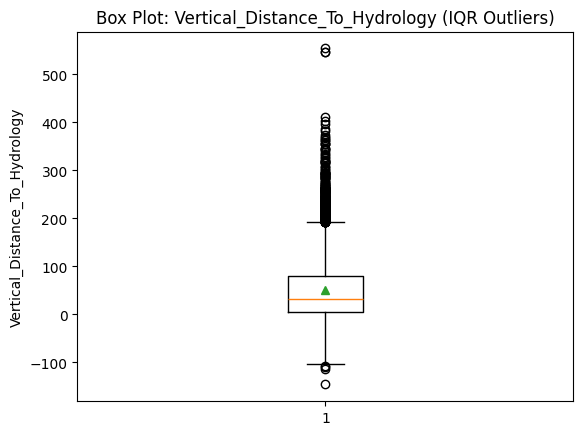

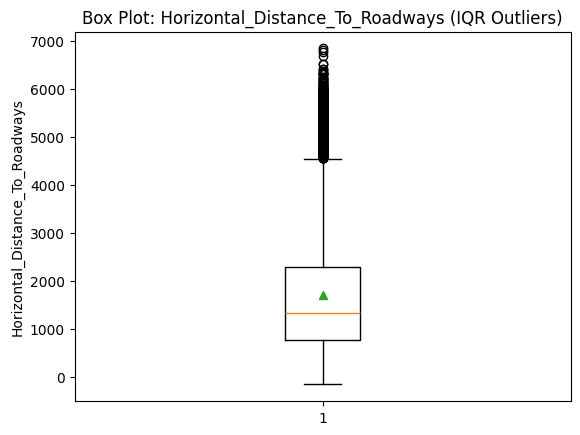


=== IQR / Outlier Summary (first 6 features) ===
                            Feature      Q1       Median           Q3  \
5   Horizontal_Distance_To_Roadways   768.0  1319.587452  2274.000000   
4    Vertical_Distance_To_Hydrology     5.0    33.000000    80.000000   
3  Horizontal_Distance_To_Hydrology    67.0   180.000000   330.000000   
2                             Slope    10.0    15.000000    22.000000   
1                            Aspect    67.0   127.000000   256.532333   
0                         Elevation  2378.0  2752.000000  3096.000000   

           IQR  LowerBound   UpperBound  OutlierCount  
5  1506.000000  -1491.0000  4533.000000           573  
4    75.000000   -107.5000   192.500000           411  
3   263.000000   -327.5000   724.500000           377  
2    12.000000     -8.0000    40.000000            46  
1   189.532333   -217.2985   540.830833             0  
0   718.000000   1301.0000  4173.000000             0  

Entropy:
Imbalanced Train: 0.5923
Pure all-0 

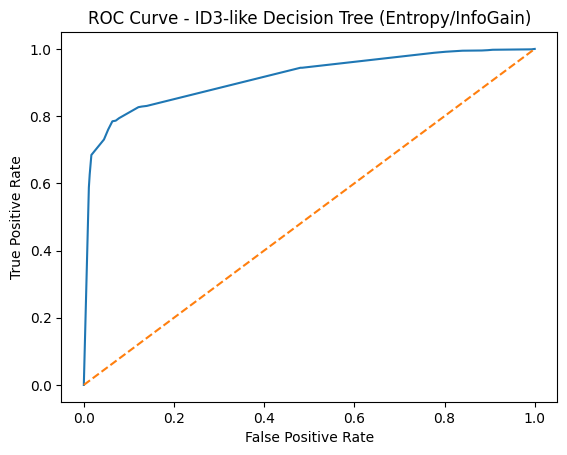


--- Decision Tree Rules (truncated to depth 4) ---

|--- Elevation <= 2703.50
|   |--- Horizontal_Distance_To_Hydrology <= 17.88
|   |   |--- Horizontal_Distance_To_Hydrology <= 13.82
|   |   |   |--- Horizontal_Distance_To_Roadways <= 14.99
|   |   |   |   |--- Wilderness_Area4 <= 0.13
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Wilderness_Area4 >  0.13
|   |   |   |   |   |--- class: 0
|   |   |   |--- Horizontal_Distance_To_Roadways >  14.99
|   |   |   |   |--- Elevation <= 2319.12
|   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |--- Elevation >  2319.12
|   |   |   |   |   |--- truncated branch of depth 2
|   |   |--- Horizontal_Distance_To_Hydrology >  13.82
|   |   |   |--- Horizontal_Distance_To_Fire_Points <= 19.25
|   |   |   |   |--- Soil_Type4 <= 0.06
|   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |--- Soil_Type4 >  0.06
|   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- Horizontal_Distance_To_Fire_Po

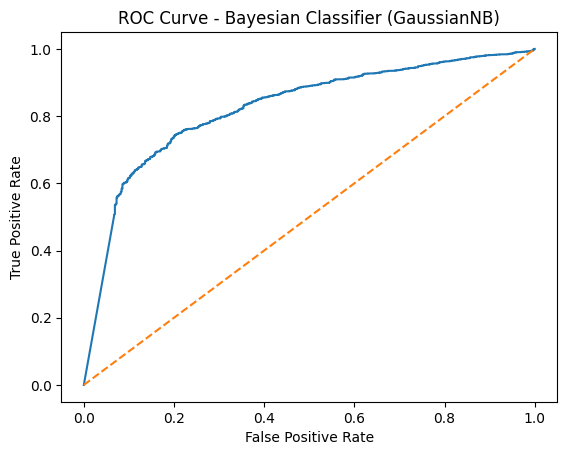


Best MLP params: {'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (64, 32), 'mlp__learning_rate_init': 0.001}

=== MLP Backprop NN (Tuned) ===
Confusion Matrix:
 [[ 332  205]
 [ 151 3062]]
TN:332 FP:205 FN:151 TP:3062
Accuracy: 0.9051
Precision: 0.9373
Recall/Sensitivity: 0.9530
Specificity: 0.6182
F1 Score: 0.9451
ROC AUC: 0.9132


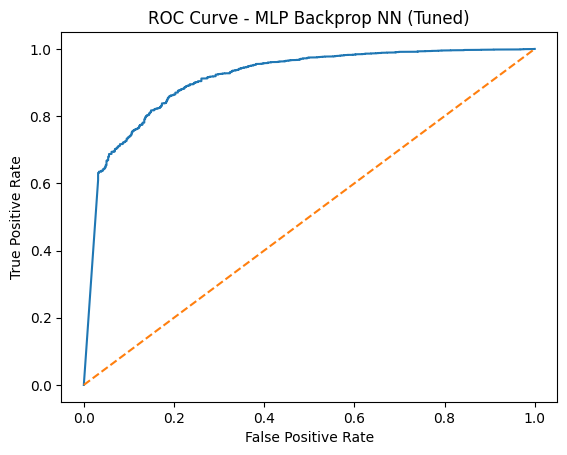


MLP Train Acc: 0.9956 | Test Acc: 0.9051
Bias/Variance Diagnosis: High Variance (overfitting)

=== Multivariate Linear Regression (Predict one feature) ===
Target: Elevation
RMSE: 154.5661
R2  : 0.865


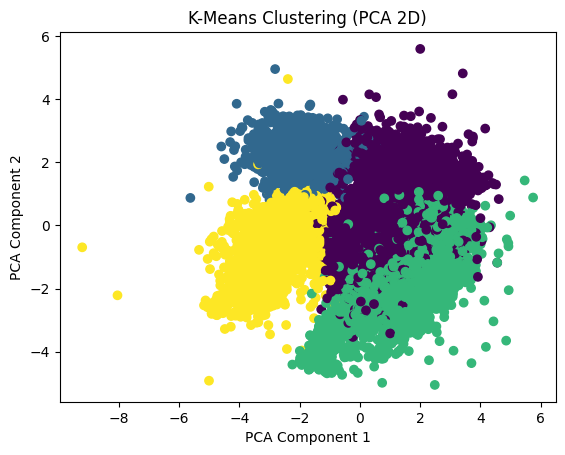

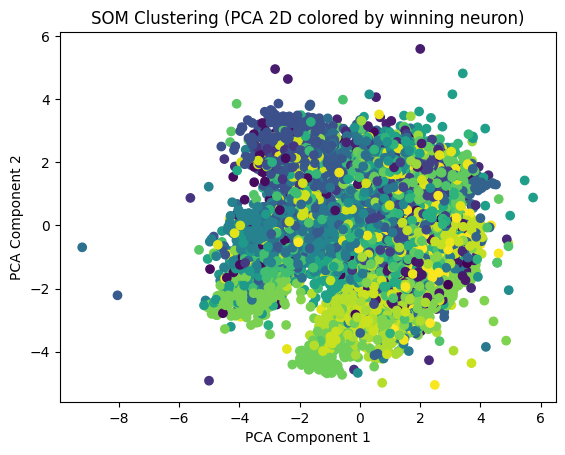

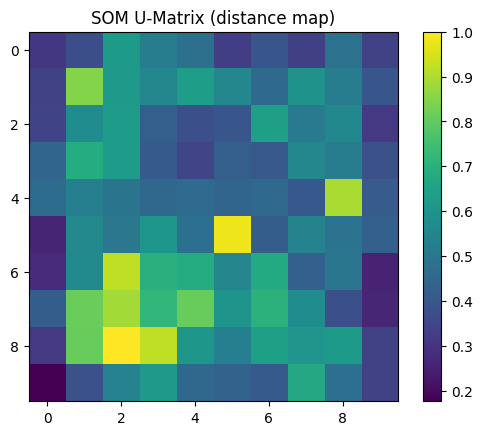

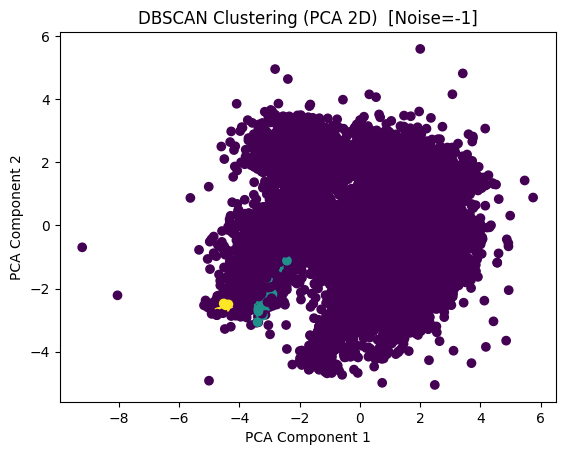

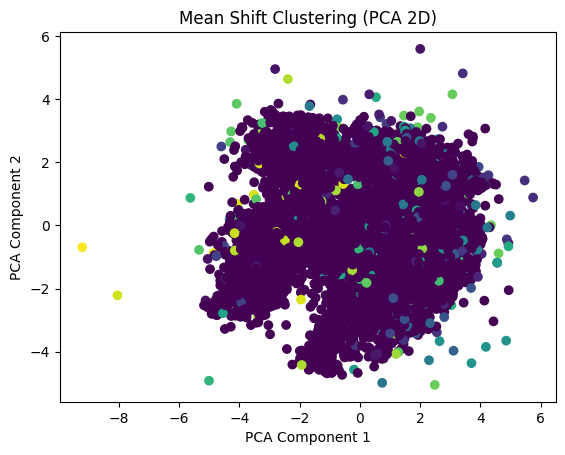


=== Silhouette Scores (Train, Unsupervised) ===
KMeans: Silhouette Score = 0.0558
SOM: Silhouette Score = 0.1677
DBSCAN: Silhouette Score = 0.5774
MeanShift: Silhouette Score = 0.1861

DONE ✅ Capstone 4 executed (Modules 1–8) with graphs.


In [1]:
# ============================================================
# CAPSTONE PROJECT 4: LAND COVER (KAGGLE CSV) – Forest Cover Type
# File: train.csv (uploaded to /content/sample_data/train.csv)
# Modules 1–8 (end-to-end) + Cluster GRAPHS (KMeans/SOM/DBSCAN/MeanShift)
# Runtime-safe: samples data to avoid RAM/time issues
# ============================================================

# -------------------------
# 0) Install (Colab only)
# -------------------------
# If you're in Colab, run once:
!pip -q install imbalanced-learn minisom

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import skew

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    confusion_matrix, accuracy_score, roc_auc_score, roc_curve,
    silhouette_score, mean_squared_error, r2_score
)

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, PowerTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression

from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from minisom import MiniSom

# ------------------------------------------------------------
# CONFIG (You can tweak)
# ------------------------------------------------------------
DATA_PATH = "/content/sample_data/train.csv"   # <- your upload location
SAMPLE_N  = 15000                               # runtime-safe sample
MISSING_RATE = 0.05                             # inject missingness for Module 1
RANDOM_STATE = 42

# ------------------------------------------------------------
# 1) LOAD DATASET (KAGGLE train.csv)
# ------------------------------------------------------------
df_raw = pd.read_csv(DATA_PATH)
print("Raw shape:", df_raw.shape)
print(df_raw.head())

# Identify target column (commonly: "Cover_Type" in covtype; in competition it can differ)
# We'll auto-detect a good candidate.
possible_targets = [c for c in df_raw.columns if c.lower() in ["cover_type", "covertype", "target", "label", "class", "cover"]]
if len(possible_targets) > 0:
    target_col = possible_targets[0]
else:
    # fallback: last column often is target
    target_col = df_raw.columns[-1]

print("\nDetected target column:", target_col)

# Drop obvious ID columns if present
id_like = [c for c in df_raw.columns if c.lower() in ["id"]]
df = df_raw.drop(columns=id_like) if len(id_like) else df_raw.copy()

# ------------------------------------------------------------
# SAMPLE to keep runtime safe
# ------------------------------------------------------------
if len(df) > SAMPLE_N:
    df = df.sample(n=SAMPLE_N, random_state=RANDOM_STATE).reset_index(drop=True)

print("Working shape (after sampling):", df.shape)

# Separate X/y
y_full = df[target_col].copy()
X_full = df.drop(columns=[target_col]).copy()

# Keep only numeric columns (Forest cover data is numeric)
X_full = X_full.select_dtypes(include=[np.number])

print("\nFeature shape:", X_full.shape, "| Target shape:", y_full.shape)

# ------------------------------------------------------------
# Make a BINARY classification target for CM + ROC metrics
# (You can still report multiclass distribution, but ROC is clean for binary)
# We'll define the most frequent class as 0, all others as 1.
# ------------------------------------------------------------
most_common = y_full.value_counts().idxmax()
y_bin = (y_full != most_common).astype(int)
print("\nBinary target definition: class 0 =", most_common, "vs others = 1")
print("Binary class counts:\n", y_bin.value_counts())

# ------------------------------------------------------------
# Module 1: Data Cleaning (Make missing values exist + Imputation)
# ------------------------------------------------------------
# Inject missing values into features (since Kaggle CSVs usually have none)
rng = np.random.default_rng(RANDOM_STATE)
X_missing = X_full.copy()

for c in X_missing.columns:
    mask = rng.random(len(X_missing)) < MISSING_RATE
    X_missing.loc[mask, c] = np.nan

print("\nMissing values after injection:")
print(X_missing.isna().sum().sort_values(ascending=False).head(10))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_missing, y_bin, test_size=0.25, random_state=RANDOM_STATE, stratify=y_bin
)

num_cols = X_train.columns.tolist()

# Simple Imputer (median)
simple_imputer = SimpleImputer(strategy="median")
Xtr_simple = pd.DataFrame(simple_imputer.fit_transform(X_train), columns=num_cols, index=X_train.index)
Xte_simple = pd.DataFrame(simple_imputer.transform(X_test), columns=num_cols, index=X_test.index)

# KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5, weights="distance")
Xtr_knn = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=num_cols, index=X_train.index)
Xte_knn = pd.DataFrame(knn_imputer.transform(X_test), columns=num_cols, index=X_test.index)

# Iterative Imputer
iter_imputer = IterativeImputer(random_state=RANDOM_STATE, max_iter=15)
Xtr_iter = pd.DataFrame(iter_imputer.fit_transform(X_train), columns=num_cols, index=X_train.index)
Xte_iter = pd.DataFrame(iter_imputer.transform(X_test), columns=num_cols, index=X_test.index)

print("\nMissing after IterativeImputer (train):", int(Xtr_iter.isna().sum().sum()))

# Choose ONE imputed dataset for rest (recommended: Iterative)
Xtr = Xtr_iter.copy()
Xte = Xte_iter.copy()

# ------------------------------------------------------------
# Module 2: Symmetry check (Mean, Median, Skewness)
# ------------------------------------------------------------
def classify_skew(sk):
    if abs(sk) < 0.5:
        return "Symmetric"
    elif sk >= 0.5:
        return "Right-Skewed"
    else:
        return "Left-Skewed"

sym_rows = []
for c in num_cols:
    mean_v = Xtr[c].mean()
    med_v  = Xtr[c].median()
    sk     = skew(Xtr[c], bias=False)
    sym_rows.append([c, mean_v, med_v, sk, classify_skew(sk)])

symmetry_df = pd.DataFrame(sym_rows, columns=["Feature","Mean","Median","Skewness","Class"])
print("\n=== Symmetry Report (Train) ===")
print(symmetry_df.sort_values("Skewness").head(15))

# ------------------------------------------------------------
# Module 3: Preprocessing + Transformations to fix skewness
# ------------------------------------------------------------
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler(),
    "MaxAbsScaler": MaxAbsScaler()
}

print("\n=== Scaler Demo (mean/std of first 5 features) ===")
some_cols = num_cols[:5]
for sname, scaler in scalers.items():
    X_scaled = pd.DataFrame(scaler.fit_transform(Xtr[some_cols]), columns=some_cols, index=Xtr.index)
    print(f"\n{sname}:\n", X_scaled.agg(["mean","std"]).round(3))

# Fix skewness using Yeo-Johnson on skewed features
skewed_features = symmetry_df.loc[symmetry_df["Skewness"].abs() >= 0.5, "Feature"].tolist()
print("\nSkewed features (|skew|>=0.5):", len(skewed_features))

Xtr_tf = Xtr.copy()
Xte_tf = Xte.copy()

if len(skewed_features) > 0:
    pt = PowerTransformer(method="yeo-johnson", standardize=False)
    Xtr_tf[skewed_features] = pt.fit_transform(Xtr[skewed_features])
    Xte_tf[skewed_features] = pt.transform(Xte[skewed_features])

# Skewness before/after (show top 10 by abs skew)
sk_fix = []
for c in num_cols:
    sk_before = float(symmetry_df.loc[symmetry_df["Feature"] == c, "Skewness"].values[0])
    sk_after  = float(skew(Xtr_tf[c], bias=False))
    sk_fix.append([c, sk_before, sk_after])

sk_fix_df = pd.DataFrame(sk_fix, columns=["Feature","Skew_Before","Skew_After"])
sk_fix_df["AbsBefore"] = sk_fix_df["Skew_Before"].abs()
print("\n=== Skewness Fix (Top 10 most skewed) ===")
print(sk_fix_df.sort_values("AbsBefore", ascending=False).head(10))

# ------------------------------------------------------------
# Module 4: Univariate Visualization (Bar, Histogram, Box/IQR)
# ------------------------------------------------------------
# Bar plot: binary class distribution
plt.figure()
pd.Series(y_train).value_counts().sort_index().plot(kind="bar")
plt.title("Binary Class Count (Train)")
plt.xlabel(f"0 = {most_common} (majority), 1 = others")
plt.ylabel("Count")
plt.show()

# Histograms for first 6 features (avoid plotting 50+)
for c in num_cols[:6]:
    plt.figure()
    plt.hist(Xtr[c], bins=25)
    plt.title(f"Histogram: {c} (Train, Imputed)")
    plt.xlabel(c)
    plt.ylabel("Frequency")
    plt.show()

# Box plot + IQR outliers for first 6 features
def iqr_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5*iqr
    high = q3 + 1.5*iqr
    outs = series[(series < low) | (series > high)]
    return q1, series.median(), q3, iqr, low, high, outs

out_summary = []
for c in num_cols[:6]:
    q1, med, q3, iqr, low, high, outs = iqr_outliers(Xtr[c])
    out_summary.append([c, q1, med, q3, iqr, low, high, len(outs)])

    plt.figure()
    plt.boxplot(Xtr[c], vert=True, showmeans=True)
    plt.title(f"Box Plot: {c} (IQR Outliers)")
    plt.ylabel(c)
    plt.show()

out_df = pd.DataFrame(out_summary, columns=["Feature","Q1","Median","Q3","IQR","LowerBound","UpperBound","OutlierCount"])
print("\n=== IQR / Outlier Summary (first 6 features) ===")
print(out_df.sort_values("OutlierCount", ascending=False))

# ------------------------------------------------------------
# Module 5: Balancing (Under, Over, SMOTE) + Entropy + Bias/Variance
# ------------------------------------------------------------
def entropy_of_labels(labels):
    labels = np.asarray(labels).astype(int)
    counts = np.bincount(labels)
    probs = counts[counts > 0] / counts.sum()
    return float(-(probs * np.log2(probs)).sum())

H_imbal = entropy_of_labels(y_train)
H_pure0 = entropy_of_labels(np.zeros_like(y_train))
H_pure1 = entropy_of_labels(np.ones_like(y_train))

print("\nEntropy:")
print("Imbalanced Train:", round(H_imbal, 4))
print("Pure all-0      :", round(H_pure0, 4))
print("Pure all-1      :", round(H_pure1, 4))

# Use transformed features for balancing
Xtr_base = Xtr_tf.copy()
ytr_base = pd.Series(y_train, index=Xtr_base.index)

rus = RandomUnderSampler(random_state=RANDOM_STATE)
ros = RandomOverSampler(random_state=RANDOM_STATE)
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)

X_rus, y_rus = rus.fit_resample(Xtr_base, ytr_base)
X_ros, y_ros = ros.fit_resample(Xtr_base, ytr_base)
X_smt, y_smt = smote.fit_resample(Xtr_base, ytr_base)

print("\nClass counts:")
print("Imbalanced:", np.bincount(ytr_base.values))
print("UnderSample:", np.bincount(y_rus.values))
print("OverSample :", np.bincount(y_ros.values))
print("SMOTE      :", np.bincount(y_smt.values))

print("\nEntropy:")
print("Imbalanced:", round(entropy_of_labels(ytr_base.values), 4))
print("UnderSample:", round(entropy_of_labels(y_rus.values), 4))
print("OverSample :", round(entropy_of_labels(y_ros.values), 4))
print("SMOTE      :", round(entropy_of_labels(y_smt.values), 4))

def bias_variance_label(train_acc, test_acc, gap_threshold=0.08, low_threshold=0.70):
    gap = train_acc - test_acc
    if train_acc < low_threshold and test_acc < low_threshold:
        return "High Bias (underfitting)"
    if gap > gap_threshold and train_acc >= low_threshold:
        return "High Variance (overfitting)"
    if train_acc >= low_threshold and test_acc >= low_threshold and gap <= gap_threshold:
        return "Low Bias & Low Variance (good generalization)"
    return "Mixed/Needs tuning"

# ------------------------------------------------------------
# Module 6: Supervised Models (Binary) + Rules + ROC
# ------------------------------------------------------------
def classification_report_from_cm(y_true, y_pred, y_prob=None, title=""):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy  = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) else 0.0
    f1 = (2*precision*recall)/(precision+recall) if (precision+recall) else 0.0

    print(f"\n=== {title} ===")
    print("Confusion Matrix:\n", cm)
    print(f"TN:{tn} FP:{fp} FN:{fn} TP:{tp}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1 Score: {f1:.4f}")

    if y_prob is not None:
        auc = roc_auc_score(y_true, y_prob)
        print(f"ROC AUC: {auc:.4f}")
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], linestyle="--")
        plt.title(f"ROC Curve - {title}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()

    return accuracy

X_train_model = Xtr_base.copy()
X_test_model  = Xte_tf.copy()

# a) ID3-like Decision Tree (Entropy / Information Gain) + rules
dt = DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state=RANDOM_STATE)
dt.fit(X_train_model, y_train)

y_pred_dt = dt.predict(X_test_model)
y_prob_dt = dt.predict_proba(X_test_model)[:, 1]
acc_dt = classification_report_from_cm(y_test, y_pred_dt, y_prob_dt, "ID3-like Decision Tree (Entropy/InfoGain)")

rules = export_text(dt, feature_names=list(X_train_model.columns), max_depth=4)
print("\n--- Decision Tree Rules (truncated to depth 4) ---\n")
print(rules)

# b) Bayesian Classifier (GaussianNB)
nb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("nb", GaussianNB())
])
nb_pipe.fit(X_train_model, y_train)
y_pred_nb = nb_pipe.predict(X_test_model)
y_prob_nb = nb_pipe.predict_proba(X_test_model)[:, 1]
acc_nb = classification_report_from_cm(y_test, y_pred_nb, y_prob_nb, "Bayesian Classifier (GaussianNB)")

# c) MLP Backprop NN + hyper-tuning (keep grid small for runtime)
mlp_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(max_iter=2000, random_state=RANDOM_STATE))
])

param_grid = {
    "mlp__hidden_layer_sizes": [(32,), (64,), (64,32)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [1e-4, 1e-3],
    "mlp__learning_rate_init": [1e-3, 5e-4],
}

gs = GridSearchCV(mlp_pipe, param_grid=param_grid, scoring="f1", cv=3, n_jobs=-1, verbose=0)
gs.fit(X_train_model, y_train)

print("\nBest MLP params:", gs.best_params_)
best_mlp = gs.best_estimator_

y_pred_mlp = best_mlp.predict(X_test_model)
y_prob_mlp = best_mlp.predict_proba(X_test_model)[:, 1]
acc_mlp = classification_report_from_cm(y_test, y_pred_mlp, y_prob_mlp, "MLP Backprop NN (Tuned)")

train_acc_mlp = accuracy_score(y_train, best_mlp.predict(X_train_model))
test_acc_mlp  = accuracy_score(y_test, y_pred_mlp)
print("\nMLP Train Acc:", round(train_acc_mlp, 4), "| Test Acc:", round(test_acc_mlp, 4))
print("Bias/Variance Diagnosis:", bias_variance_label(train_acc_mlp, test_acc_mlp))

# d) Multivariate Linear Regression (prediction)
# Predict one numeric feature from others (example: first feature)
target_reg = num_cols[0]
Xreg_train = X_train_model.drop(columns=[target_reg])
yreg_train = X_train_model[target_reg]
Xreg_test  = X_test_model.drop(columns=[target_reg])
yreg_test  = X_test_model[target_reg]

reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])
reg_pipe.fit(Xreg_train, yreg_train)
yreg_pred = reg_pipe.predict(Xreg_test)

rmse = np.sqrt(mean_squared_error(yreg_test, yreg_pred))
r2   = r2_score(yreg_test, yreg_pred)
print("\n=== Multivariate Linear Regression (Predict one feature) ===")
print("Target:", target_reg)
print("RMSE:", round(rmse, 4))
print("R2  :", round(r2, 4))

# ------------------------------------------------------------
# Module 7: Unsupervised Learning + GRAPHS (PCA 2D)
# ------------------------------------------------------------
# Use scaled features for clustering
X_uns = StandardScaler().fit_transform(X_train_model)

# PCA for plotting (2D)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca.fit_transform(X_uns)

def plot_clusters(title, labels):
    plt.figure()
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# a) K-Means
kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init=10)
k_labels = kmeans.fit_predict(X_uns)
plot_clusters("K-Means Clustering (PCA 2D)", k_labels)

# b) SOM
som_x, som_y = 10, 10
som = MiniSom(som_x, som_y, X_uns.shape[1], sigma=1.0, learning_rate=0.5, random_seed=RANDOM_STATE)
som.random_weights_init(X_uns)
som.train_random(X_uns, num_iteration=2000)

winners = np.array([som.winner(x) for x in X_uns])
som_labels = winners[:, 0] * som_y + winners[:, 1]
plot_clusters("SOM Clustering (PCA 2D colored by winning neuron)", som_labels)

# SOM U-Matrix
umatrix = som.distance_map()
plt.figure()
plt.imshow(umatrix)
plt.title("SOM U-Matrix (distance map)")
plt.colorbar()
plt.show()

# c) DBSCAN
db = DBSCAN(eps=0.7, min_samples=10)
db_labels = db.fit_predict(X_uns)
plot_clusters("DBSCAN Clustering (PCA 2D)  [Noise=-1]", db_labels)

# d) Mean Shift
bw = estimate_bandwidth(X_uns, quantile=0.2, n_samples=min(500, X_uns.shape[0]))
bw = bw if (bw is not None and bw > 0) else 1.0
ms = MeanShift(bandwidth=bw, bin_seeding=True)
ms_labels = ms.fit_predict(X_uns)
plot_clusters("Mean Shift Clustering (PCA 2D)", ms_labels)

# ------------------------------------------------------------
# Module 8: Silhouette Score for Clustering
# ------------------------------------------------------------
def safe_silhouette(X, labels, name):
    unique = set(labels)
    if len(unique) < 2:
        print(f"{name}: Silhouette not valid (only 1 cluster).")
        return None
    if unique == {-1}:
        print(f"{name}: Silhouette not valid (all noise).")
        return None
    if -1 in unique:
        mask = labels != -1
        if len(set(labels[mask])) < 2:
            print(f"{name}: Silhouette not valid (after removing noise, <2 clusters).")
            return None
        score = silhouette_score(X[mask], labels[mask])
    else:
        score = silhouette_score(X, labels)
    print(f"{name}: Silhouette Score = {score:.4f}")
    return score

print("\n=== Silhouette Scores (Train, Unsupervised) ===")
safe_silhouette(X_uns, k_labels, "KMeans")
safe_silhouette(X_uns, som_labels, "SOM")
safe_silhouette(X_uns, db_labels, "DBSCAN")
safe_silhouette(X_uns, ms_labels, "MeanShift")

print("\nDONE ✅ Capstone 4 executed (Modules 1–8) with graphs.")
